# 토치(Torch)를 이용한 딥 러닝: 60분에 배우기

Original version (English): http://nbviewer.ipython.org/github/soumith/talks/blob/master/gtc2015/Deep%20Learning%20with%20Torch.ipynb

사전 발표 자료: https://github.com/soumith/talks/blob/master/gtc2015/slides.pdf?raw=true

###이 발표의 목적
* 토치와 신경망 패키지를 내부까지 들여다보지 않고 사용만 하는 수준에서 이해
* 작은 신경망 하나를 CPU와 GPU에서 훈련

##토치란 무엇인가?

토치는 Lua[JIT]에 기반한 과학 계산 프레임워크 입니다. 토치는 강력한 CPU와 CUDA 처리 능력을 갖고 있습니다.

토치의 강점들:

* CUDA 처리가 가능한 효율적 텐서 라이브러리 (NumPy 같은) 
* 신경망 패키지 -- 자동 미분 가능한 임의의 비순환 계산 그래프들 생성
   * 빠른 CUDA 연산 지원
* 좋은 커뮤니티와 산업계 지원 - 수백 개의 커뮤니티가 패키지들을 만들고 유지보수.
* 사용하기 쉬운 멀티-GPU 지원 그리고 신경망의 병렬화

http://torch.ch  
https://github.com/torch/torch7/wiki/Cheatsheet

##시작하기 전에

* 루아(Lua)에 기반하고 빠른 Lua-JIT (Just-in-time 컴파일러)에서 실행됨.
* Lua 는 자바스크립트와 상당히 유사함.
   * 변수들은 `local` 키워드가 사용되지 않으면 기본적으로 전역(`global`)임
* 오직 하나의 내장 자료 구조가 있음: `{}`. 이것은 해쉬 테이블 그리고 배열로서의 이중적 역할을 함.
* 인덱스는 1부터 시작.
* `foo:bar()` 는 `foo.bar(foo)`와 같음.

##시작하기
#### 문자열(Strings), 수(numbers), 표(tables) - 아주 짧은 소개

In [ ]:
a = 'hello'

In [ ]:
print(a)

In [ ]:
b = {}

In [ ]:
b[1] = a

In [ ]:
print(b)

In [ ]:
b[2] = 30

In [ ]:
for i=1,#b do -- '#'는 루아에서 요소의 개수를 리턴하는 연산자임.
    print(b[i]) 
end

####텐서(Tensors)

In [ ]:
a = torch.Tensor(5,3) -- 5x3 행렬 생성, 초기화되지 않음.

In [ ]:
a = torch.rand(5,3)
print(a)

In [ ]:
b=torch.rand(3,4)

In [ ]:
-- 행렬-행렬 곱: 문법 1
a*b 

In [ ]:
-- 행렬-행렬 곱: 문법 2
torch.mm(a,b) 

In [ ]:
-- 행렬-행렬 곱: 문법 3
c=torch.Tensor(5,4)
c:mm(a,b) -- a*b 결과를 c에 저장

####쿠다 텐서(CUDA Tensors)
텐서들은 :cuda 함수를 사용하여 GPU로 옮겨질 수 있습니다.

In [ ]:
require 'cutorch';
a = a:cuda()
b = b:cuda()
c = c:cuda()
c:mm(a,b) -- GPU에서 계산됨

####연습: 두 텐서의 합

In [ ]:
function addTensors(a,b)
    return a -- a로 고정
end

In [ ]:
a = torch.ones(5,2)
b = torch.Tensor(3,4):fill(4)
print(addTensors(a,b))

### 신경망(Neural Networks)
토치에서 신경망은 `nn` 패키지를 사용하여 만들어질 수 있습니다.

In [12]:
require 'nn';

`모듈들`은 신경망을 구축하기 위한 요소(building block)들입니다. 각 모듈은 그 자체로 신경망들 입니다, 그러나 복잡한 신경망을 만들기 위해 다른 신경망들과 `컨테이너들`을 사용하여 합쳐질 수 있습니다.

이를테면, 숫자 영상들을 분류하는 이 네트워크를 보십시오:
![LeNet](http://fastml.com/images/cifar/lenet5.png)

이것은 단순한 피드포워드 망 입니다.
이 네트웤는 한 입력을 받아, 그것을 여러 층들에 걸쳐 전달합니다, 그리고 마지막으로 출력을 내보냅니다.

이런 네트워크의 컨테이너는 `nn.Sequential` 입니다. `nn.Sequential`은 입력을 여러 층들에 걸쳐 전달합니다.

In [ ]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 1 입력 영상 채널, 6 출력 채널, 5x5 컨볼루션 커널
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- 2x2 윈도우들을 통해 보는 맥스 풀링(max-pooling) 연산 그리고 그 각 윈도우에서 최대값을 찾음.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- 16x5x5의 3 차원 텐서를 16*5*5의 1 차원 텐서로 변환 
net:add(nn.Linear(16*5*5, 120))             -- 완전 연결된(fully connected) 층 (입력과 가중치들 사이의 행렬 곱)
net:add(nn.Linear(120, 84))
net:add(nn.Linear(84, 10))                   -- 10 은 출력 층의 노드 수.
net:add(nn.LogSoftMax())                     -- 그 출력을 로그 확률로 변환. 분류 문제들에 유용함.

print('Lenet5\n' .. net:__tostring());

nn 컨테이너들의 다른 예들이 아래 그림에 보여집니다.
![containers](https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/nn_containers.png)

모든 토치의 신경망 모듈은 자동 미분 기능을 갖습니다. `:forward(input)` 함수는 한 주어진 입력에서 한 신경망의 출력을 계산합니다. `:backward(input, gradient)` 함수는 연쇄 법칙(chain rule)으로 그 망에 있는 각 뉴런의 역전파 미분값을 계산합니다. (참조: http://roboticist.tistory.com/501)

In [ ]:
input = torch.rand(1,32,32) -- 한 랜덤 텐서를 네트워크 입력으로 전달

In [ ]:
output = net:forward(input)

In [ ]:
print(output)

In [ ]:
net:zeroGradParameters() -- 네트워크의 기울기(gradient) 버퍼들을 0으로 초기화 (나중에 다시 나옴)

In [ ]:
gradInput = net:backward(input, torch.rand(10))

In [ ]:
print(#gradInput)

### 판별 기준: 손실 함수 정의
한 모델이 무언가 하도록 배우기 원할 때, 그 모델에게 어떻게 하는 것이 잘하는 것인지 피드백을 주어야 합니다. 그 모델의 성능을 측정하는 객관적 수치를 계산하는 함수를 __손실 함수__라 부릅니다.

전형적인 손실함수는 모델의 출력과 정답을 입력으로 받아 그 모델의 성능을 정량화하는 값을 계산합니다.

그 모델은 더 적은 손실을 갖도록 자신을 고쳐나갑니다.

토치에서, 손실 함수들은 신경망 모듈들처럼 구현됩니다, 그리고 자동 미분 기능을 갖습니다. 손실 함수에는 두 함수들이 있습니다: `forward(input, target)`, `backward(input, target)`가 그것들입니다.

이를테면:

In [ ]:
criterion = nn.ClassNLLCriterion() -- 다부류 분류를 위한 negative log-likelihood criterion
criterion:forward(output, 3) -- 정답이 부류 넘버 3이라고 합시다.
gradients = criterion:backward(output, 3)

In [ ]:
gradInput = net:backward(input, gradients)

#####지금까지 배운 것들
* 네트워크는 많은 계산 층들을 가질 수 있다.
* 네트워크는 forward pass에서 한 입력을 받아 한 출력을 생성한다. 
* 판별 함수(criterion)는 네트워크의 손실과 그 네트워크 출력에 대한 미분값(gradient)들을 계산한다. 
* 네트워크는 backward pass에서 (입력, 미분값) 쌍을 입력 받아 그 네트워크 각 층의 뉴런들에 대한 미분값(gradient)들을 계산한다.

##### 빠진 내용
> 한 신경망 층은 학습할 수 있는 매개변수들을 갖는가 갖지 않는가.

한 컨볼루션 층은 그것의 컨볼루션 커널들을 학습합니다. 목적은 입력에 적응하여 해결하고자 하는 문제가 풀리도록 만드는 것입니다.
맥스풀링 층에는 학습할 수 있는 매개변수들이 없습니다. 맥스풀링 층은 단지 그것의 로컬 위도우들에서 최댓값을 찾는 역할만 합니다.

토치에서 학습할 수 있는 가중치(weight)들을 갖는 한 층은 보통 .weight (그리고 선택적으로, .bias) 필드들을 가질 것입니다.

In [ ]:
m = nn.SpatialConvolution(1,3,2,2) -- 새 개의 2x2 커널들 학습
print(m.weight) -- 초기에, 가중치들은 랜덤하게 초기화됨

In [ ]:
print(m.bias) -- 한 컨볼루션 층에서 이 연산은: output = convolution(input,weight) + bias

한 학습 가능 층에는 두 개의 또다른 다른 중요한 필드들이 있습니다. gradWeight 그리고 gradBias가 그것입니다.
gradWeight는 그 층의 각 가중치에 대한 미분값들을 누적합니다, 그리고 gradBias는 그 층의 각 bias에 대한 미분값들을 누적합니다.

#### 네트워크 훈련하기

만약 당신이 추계적 경사 강하(Stochastic Gradient Descent, SGD)를 사용하면 네트워크는 보통 식 1로 갱신됩니다: 
> weight = weight + learningRate * gradWeight [식 1]

이 식은 시간이 지남에따라 네트워크 가중치들을 출력 손실이 감소하도록 조절합니다.

이제 한 가지 빠진 부분에 대해 논의해 보겠습니다. 누가 신경망의 각 층을 방문하고 식 1에 따라 가중치들을 갱신할까요?

여러 답이 있지만, 우리는 가장 단순한 답을 사용하겠습니다.
즉, 단순히 신경망 모듈에 탑재된 SGD를 사용할 것입니다: [__nn.StochasticGradient__](https://github.com/torch/nn/blob/master/doc/training.md#stochasticgradientmodule-criterion).

그것은 :train(dataset) 함수를 갖습니다. 그 함수는 데이터셋(dataset)을 입력받아 그 데이터셋 안의 다른 샘플들을 네트워크에 보여줌으로써 당신의 네트워크를 훈련시킵니다.

### 데이터는 어떠한가?
일반적으로, 영상, 문자, 오디오 또는 비디오 데이터를 다뤄야만 할 때, 그 데이터를 _torch.Tensor_ 또는 루아 테이블로 로드하기 위해 다음 표준 함수들을 사용할 수 있습니다:
[__image.load__](https://github.com/torch/image#res-imageloadfilename-depth-tensortype) 또는 [__audio.load__](https://github.com/soumith/lua---audio#usage).

우리의 네트워크를 훈련시키기위해 단순한 데이터를 사용해봅시다.

우리는 CIFAR-10 데이터셋을 사용할 것입니다. CIFAR-10은 10개의 부류(class)들을 갖습니다: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.
  
CIFAR-10 영상들의 크기는 3x32x32 입니다. 즉, 32x32 픽셀 크기의 3 채널 컬러 영상들입니다.
![CIFAR-10 image](https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png)

CIFAR-10에는 총 5만 개의 훈련 영상과 1만 개의 시험 영상들이 있습니다. 

__이제 우리의 첫 토치 신경망을 훈련시키기 위한 다섯 단계를 남겨두고 있습니다__
1. 데이터 로드 및 정규화(normalize)
2. 신경망 정의
3. 손실 함수 정의
4. 훈련 데이터로 네트워크 훈련
5. 시험 데이터로 네트워크 시험

__1. 데이터 로드 및 정규화__

오늘, 시간 절약을 위해, 우리는 그 데이터를 4차원 토치 ByteTensor로 미리 준비하였습니다. 훈련 데이터의 크기는 10000x3x32x32 그리고 시험 데이터의 크기는 10000x3x32x32 입니다.
그 데이터를 로드하여 조사해봅시다.

In [1]:
os.execute('wget -c https://s3.amazonaws.com/torch7/data/cifar10torchsmall.zip')
os.execute('unzip cifar10torchsmall.zip')
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [2]:
print(trainset)

{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [3]:
print(#trainset.data)


 10000
     3
    32
    32
[torch.LongStorage of size 4]



재미를 위해, 한 영상을 디스플레이 해봅시다:

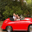

automobile	


In [4]:
itorch.image(trainset.data[100]) -- 데이터셋 안의 100번 째 영상을 디스플레이
print(classes[trainset.label[100]])

이제, 데이터셋이 __nn.StochasticGradient__에 사용될 수 있도록 준비하기 위해, [문서](https://github.com/torch/nn/blob/master/doc/training.md#traindataset)에 따라 몇 가지 해야할 것들이 있습니다.
1. 데이터셋은 :size() 함수를 가져야만 합니다.
2. 데이터셋은 [i] 인덱스 연산자를 가져야만 합니다. 이는 dataset[i]가 그 데이터셋 안의 i번 째 샘플을 리턴하도록 하기 위함입니다.

그 둘은 빠르게 될 수 있습니다:

In [5]:
-- 지금은 setmetatable을 무시하십시오, 이 튜토리얼의 범위를 벗어나는 특성이기 때문입니다. setmetatable은 인덱스 연산자를 셋팅합니다.
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- 데이터를 ByteTensor에서 DoubleTensor로 변환합니다.

function trainset:size() 
    return self.data:size(1) 
end

In [6]:
print(trainset:size()) -- 단지 테스트 목적

10000	


{
  1 : DoubleTensor - size: 3x32x32
  2 : 2
}


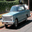

In [7]:
print(trainset[33]) -- 33번 샘플 로드.
itorch.image(trainset[33][1])

__(일반적 데이터 과학 또는 기계 학습에서) 데이터 전처리에서 가장 중요한 것들 중 하나는 그 데이터가 평균 0 그리고 표준 편차 1이 되도록 만드는 것입니다.__

그것을 이 데이터 처리의 마지막 단계로 해봅시다.

그것을 하기 위해, 텐서 인덱싱 연산자를 소개합니다.
텐서 인덱싱 연산자는 다음 예제처럼 사용됩니다:

In [8]:
redChannel = trainset.data[{ {}, {1}, {}, {}  }] -- 이것은 {모든 영상들, 첫 번째 채널, 모든 수직 픽셀들, 모든 수평 픽셀들}을 선택합니다.

In [9]:
print(#redChannel)


 10000
     1
    32
    32
[torch.LongStorage of size 4]



이 인덱싱 연산자에서, 처음은 ___[{ }]___로 시작합니다. 이 연산자는 한 차원안의 모든 요소(element)들을 리턴합니다. 반면, ___{i}___ 연산자는 한 차원안의 특정한 ___i___ 번째 요소를 리턴합니다. ___{i1, i2}___ 연산자는 ___i1___ 번째에서 ___i2___ 번째 요소들을 리턴합니다. 예를 들어, ___{3,5}___는 3, 4, 5 번째 요소들을 리턴합니다.

__연습: 데이터의 150 번째에서 300번째 요소들을 선택해보세요.__

In [ ]:
-- TODO: fill



평균 차감과 표준 편차 기반 스케일링은, 위에서 배운 인덱스 연산자를 사용하여 하면 쉽습니다:

In [10]:
mean = {} -- 평균을 저장하기 위한 공간, 테스트 셋을 정규화하기 위해 사용될 예정
stdv  = {} -- 표준 편차를 저장하기 위해 사용될 예정
for i=1,3 do -- 각 영상 채널에 대해
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- 평균 추정
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- 평균 빼기
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- 표준 편차 추정
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- 표준 편차 스케일링
end

Channel 1, Mean: 125.83175029297	


Channel 1, Standard Deviation: 63.143400842609	


Channel 2, Mean: 123.26066621094	


Channel 2, Standard Deviation: 62.369209019002	


Channel 3, Mean: 114.03068681641	


Channel 3, Standard Deviation: 66.965808411114	


이제 우리의 훈련 데이터는 정규화되어 사용할 준비가 되었습니다.

__ 2. 신경망 정의__


**연습:** 위 __신경망(Neural Networks)__ 섹션에서 신경망 코드를 복사하여 3 채널 영상들에 맞도록 수정해보십시오. (기존 것은 1 채널 영상들에 맞도록 정의되어 있습니다).
힌트: 첫 번째 층에서 숫자 1만 3으로 바꾸면 됩니다. 

__정답:__

In [13]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 3 입력 영상 채널, 6 출력 채널, 5x5 컨볼루션 커널
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- 2x2 윈도우들을 통해 보면서 최댓값을 찾는 맥스풀링 연산
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                   -- 16x5x5 3 차원 텐서를 16*5*5 1차원 텐서로 변환
net:add(nn.Linear(16*5*5, 120))            -- 완전 연결 층(fully connected layer) (입력과 가중치들 사이의 행렬 곱)
net:add(nn.Linear(120, 84))
net:add(nn.Linear(84, 10))                 -- 10은 네트워크 출력의 개수
net:add(nn.LogSoftMax())                   -- 출력을 로그 확률로 변환. 분류 문제에 유용함.

__3. 손실 함수 정의__

로그-우도(log-likelihood)를 사용해봅시다. 이것은 대부분의 분류 문제에 적합합니다.

In [14]:
criterion = nn.ClassNLLCriterion()

__4. 신경망 훈련__

여기서부터 재미있어지기 시작합니다.
우선 __nn.StochasticGradient__ 객체를 정의합시다. 그 다음 우리의 데이터셋을 그 객체의 ___:train___ 함수에 넣을 것입니다.

In [15]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 5 -- 훈련을 위해 5 에포크(epoch)만 반복.

In [ ]:
trainer:train(trainset)

__5. 네트워크 시험, 정확도 출력__

네트워크가 훈련 데이터셋에 대해 훈련되었습니다. (We have trained the network for 2 passes over the training dataset).
그러나 우리는 그 네트워크가 제대로 학습되었는지 확인할 필요가 있습니다. 
우리는 그 확인을 네트워크 출력으로 나오는 부류 레이블과 정답과 비교함으로써 합니다. 
만약 네트워크의 예측이 정확하면, 우리는 그 샘플을 바른 예측 목록에 추가합니다.

좋습니다, 첫 단계로, 익숙해지기 위해 시험 집합의 한 영상을 디스플레이 해봅시다.

In [ ]:
print(classes[testset.label[100]])
itorch.image(testset.data[100])

훈련 데이터의 평균과 표준 편차로 시험 데이터를 정규화 해봅시다.

In [ ]:
testset.data = testset.data:double()   -- Byte tensor를 Double tensor로 변환
for i=1,3 do -- 각 영상 채널에 대해
    testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- 평균 빼기    
    testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i])  -- 표준 편차 스케일링
end

In [ ]:
-- 재미를 위해, 예제-100의 평균과 표준 편차를 출력
horse = testset.data[100]
print(horse:mean(), horse:std())

좋습니다, 이제 신경망이 위 예제들을 어떻게 생각하는지 봅시다:

In [ ]:
print(classes[testset.label[100]])
itorch.image(testset.data[100])
predicted = net:forward(testset.data[100])

In [ ]:
-- 네트워크 출력은 로그 확률들 입니다. 그것들을 확률들로 바꾸기 위해 exp(x)를 취합니다.
print(predicted:exp())

이제 네트워크 예측들을 볼 수 있습니다. 네트워크는 주어진 한 영상에 대해 확률들을 각 부류에 할당하였습니다.
더 명확하게 보기 위해, 각 확률을 부류 이름으로 태깅해 봅시다:

In [ ]:
for i=1,predicted:size(1) do
    print(classes[i], predicted[i])
end

자, 좋습니다. 한 예제가 처리되었습니다, 그러나 시험 집합에서 전체적으로 얼마나 많은 예제가 정답일까요?

In [ ]:
correct = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- 실제 평균들, 내림 차순으로 정렬
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end

In [ ]:
print(correct, 100*correct/10000 .. ' % ')

That looks waaay better than chance, which is 10% accuracy (10 개의 부류들 중 랜덤하게 한 개의 부류를 선택). 네트워크가 무언가를 배운 것 같습니다.

잘 분류된 부류들은 무엇이고, 그렇지 못한 부류들은 무엇일까요:

In [ ]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- 실제 평균들, 내림 차순으로 정렬
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end

In [ ]:
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

좋습니다, 다음은 무엇일까요? 어떻게 이 신경망을 GPUs에서 운용할 수 있을까요?

#### cunn: CUDA를 사용한 GPUs에서의 신경망

In [ ]:
require 'cunn'

사용법은 간단합니다. 신경망을 가져와서, 그것을 GPU로 전송하면 됩니다:

In [ ]:
net = net:cuda()

또한 판별 객체(criterion)를 GPU로 전송합니다:

In [ ]:
criterion = criterion:cuda()

이제 데이터 입니다:

In [ ]:
trainset.data = trainset.data:cuda()

좋습니다, GPU에서 훈련해 봅시다. :) #너무 쉽습니다

In [ ]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 5 -- 훈련을 위해 5 에포크(epoch)만 반복합니다.

In [ ]:
trainer:train(trainset)

왜 CPU에 비교해 많이 가속되지 않았을까요?
네트워크 크기가 너무 작았기 때문입니다.

**연습** 네트워크 사이즈를 키워보십시오 (nn.SpatialConvolution(...)의 인자 1와 2). 그리고 어떤 가속이 있었는지 보십시오.

**성취한 목표들:**
* 토치와 신경망 패키지를 사용하는 수준(high-level)에서 이해
* 작은 신경망을 CPU와 GPU에서 훈련

### 다음은 무엇을 볼 것인가?

* Build crazy graphs of networks: https://github.com/torch/nngraph
* 다수 GPU들로 ImageNet 훈련: https://github.com/soumith/imagenet-multiGPU.torch
* Train recurrent networks with LSTM on text: https://github.com/wojzaremba/lstm
* 더 많은 데모와 튜토리얼들: https://github.com/torch/torch7/wiki/Cheatsheet
* 토치 개발자들과 대화: http://gitter.im/torch/torch7
* 도움 요청: http://groups.google.com/forum/#!forum/torch7
